📂 Please upload your fixed Excel dataset (fixed_marketing_dataset_realistic.xlsx):


Saving fixed_marketing_dataset_balanced_v2.xlsx to fixed_marketing_dataset_balanced_v2.xlsx
✅ File uploaded successfully: fixed_marketing_dataset_balanced_v2.xlsx
✅ Dataset Loaded — Shape: (7000, 15)


,Customer_ID,Age,Annual_Income,Credit_Score,Product_Type,Product_Price,Discount_Offered(%),Ad_Calls,Ad_SMS,Ad_Social,Ad_Display,Affordability_Ratio,Ad_Intensity_Value,Ad_Intensity,Responded
0,1,40,2559730,745,Necessity,67429,22,1,33,16,6,0.0263,56,Low,1
1,2,46,4538072,324,Luxury,930638,18,3,43,30,11,0.2051,87,High,1
2,3,39,2095127,807,Luxury,776355,12,3,54,34,15,0.3706,106,High,1
3,4,28,1841070,397,Necessity,577487,12,3,33,23,7,0.3137,66,Low,1
4,5,53,1608834,567,Necessity,611380,41,1,38,22,6,0.3800,67,Low,1



⚙️ Preprocessing data and creating engineered features...
✅ Features prepared — Shape: (7000, 21)

🚀 Running 5-Fold Cross-Validation + Hyperparameter Tuning...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

🎯 Best Hyperparameters Found:
{'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 0.6}

📊 Evaluating model performance...
accuracy                 : 0.8300
precision                : 0.8658
recall                   : 0.9405
f1_score                 : 0.9016
roc_auc                  : 0.7959
log_loss                 : 0.3758
pr_auc (avg precision)   : 0.9489
balanced_accuracy        : 0.6196
matthews_corrcoef        : 0.3001

Classification Report:
               precision    recall  f1-score   support

           0     0.5106    0.2988    0.3770       241
           1     0.8658    0.9405    0.9016      1159

    accuracy                         0.8300      1400
   macro avg     0.68

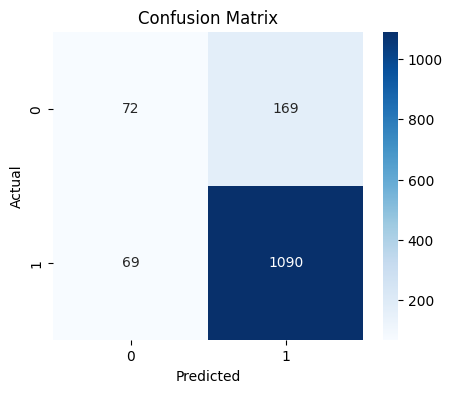

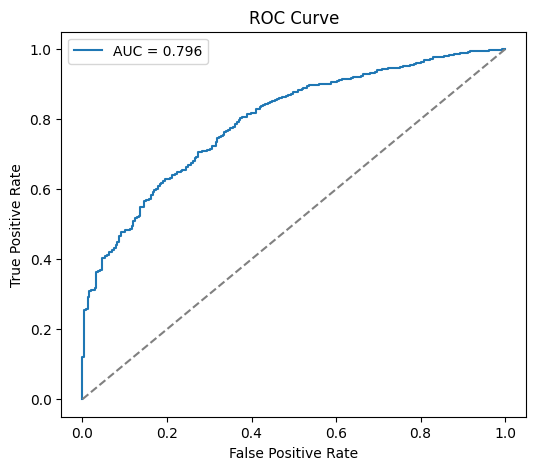

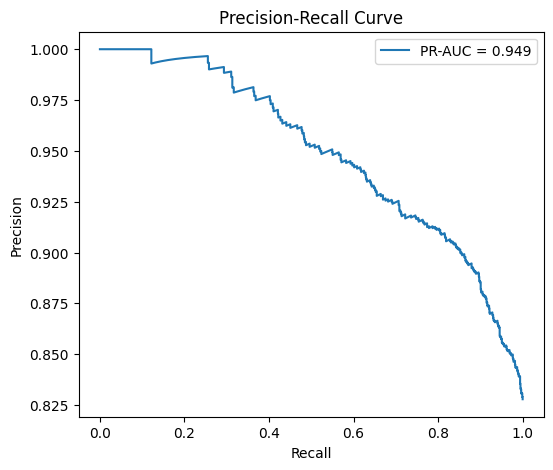

<Figure size 1000x600 with 0 Axes>

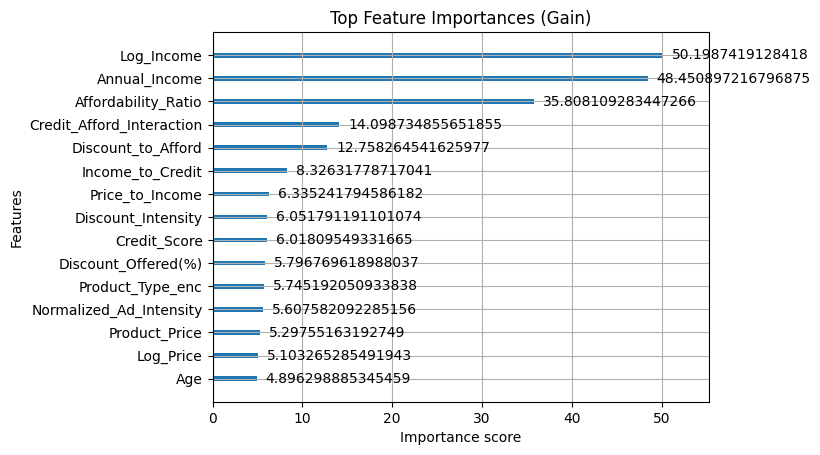


💾 Downloading trained model and metrics...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Training complete! Model and metrics downloaded successfully.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, average_precision_score,
    confusion_matrix, classification_report, matthews_corrcoef,
    balanced_accuracy_score
)
from xgboost import XGBClassifier, plot_importance
import joblib
from google.colab import files
import io
import warnings
warnings.filterwarnings("ignore")

# STEP 2 — Upload dataset
print("📂 Please upload your fixed Excel dataset (fixed_marketing_dataset_realistic.xlsx):")
uploaded = files.upload()

if not uploaded:
    raise ValueError("❌ No file uploaded. Please upload your fixed .xlsx dataset.")

file_name = list(uploaded.keys())[0]
print(f"✅ File uploaded successfully: {file_name}")

if not file_name.endswith((".xlsx", ".xls")):
    raise ValueError("Only Excel (.xlsx) files are supported!")

df = pd.read_excel(io.BytesIO(uploaded[file_name]))
print("✅ Dataset Loaded — Shape:", df.shape)
display(df.head())


# STEP 3 — Preprocessing & Feature Engineering
print("\n⚙️ Preprocessing data and creating engineered features...")

# Encode categorical features
le = LabelEncoder()
if "Product_Type" in df.columns:
    df["Product_Type_enc"] = le.fit_transform(df["Product_Type"].astype(str))

if "Ad_Intensity" in df.columns:
    df["Ad_Intensity_Num"] = df["Ad_Intensity"].map({"Low":0, "Medium":1, "High":2}).fillna(1)

# Ensure required numeric columns exist
df["Affordability_Ratio"] = df["Product_Price"] / df["Annual_Income"]
df["Normalized_Ad_Intensity"] = df["Ad_Intensity_Value"] / df["Ad_Intensity_Value"].max()
df["Log_Price"] = np.log1p(df["Product_Price"])
df["Log_Income"] = np.log1p(df["Annual_Income"])
df["Discount_to_Afford"] = df["Discount_Offered(%)"] * (1 - df["Affordability_Ratio"])
df["Credit_Afford_Interaction"] = df["Credit_Score"] * (1 - df["Affordability_Ratio"])
df["Income_to_Credit"] = df["Annual_Income"] / df["Credit_Score"]
df["Discount_Intensity"] = df["Discount_Offered(%)"] * df["Ad_Intensity_Value"]
df["Price_to_Income"] = df["Product_Price"] / df["Annual_Income"]

# Final feature selection
feature_cols = [
    "Age", "Annual_Income", "Credit_Score", "Product_Type_enc",
    "Product_Price", "Discount_Offered(%)", "Affordability_Ratio",
    "Ad_Calls", "Ad_SMS", "Ad_Social", "Ad_Display", "Ad_Intensity_Num",
    "Ad_Intensity_Value", "Normalized_Ad_Intensity",
    "Log_Price", "Log_Income", "Discount_to_Afford", "Credit_Afford_Interaction",
    "Income_to_Credit", "Discount_Intensity", "Price_to_Income"
]
X = df[feature_cols].copy()
y = df["Responded"].astype(int)

print("✅ Features prepared — Shape:", X.shape)

# STEP 4 — Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# STEP 5 — Train Model
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

print("\n🚀 Running 5-Fold Cross-Validation + Hyperparameter Tuning...")

# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter search space
param_dist = {
    "n_estimators": [200, 300, 400, 500, 700],
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],
    "max_depth": [3, 5, 6, 7, 8, 10],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "reg_lambda": [0.5, 1.0, 1.5, 2.0],
    "reg_alpha": [0, 0.1, 0.3, 0.5],
}

base_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42
)

# Randomized search (faster + better than grid search)
random_search = RandomizedSearchCV(
    base_model,
    param_distributions=param_dist,
    n_iter=40,                # number of combinations to try
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit with 5-fold CV tuning
random_search.fit(X_train, y_train)

# Best model found
model = random_search.best_estimator_

print("\n🎯 Best Hyperparameters Found:")
print(random_search.best_params_)


# STEP 6 — Evaluation
print("\n📊 Evaluating model performance...")
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_prob),
    "log_loss": log_loss(y_test, y_prob),
    "pr_auc (avg precision)": average_precision_score(y_test, y_prob),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred)
}

for k, v in metrics.items():
    print(f"{k:25s}: {v:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve, precision_recall_curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {metrics['roc_auc']:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR-AUC = {metrics['pr_auc (avg precision)']:.3f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

# Feature Importance
plt.figure(figsize=(10,6))
plot_importance(model, max_num_features=15, importance_type='gain', show_values=True)
plt.title("Top Feature Importances (Gain)")
plt.show()

# STEP 7 — Save Outputs
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['value'])
metrics_df.to_csv("training_evaluation_metrics.csv")
model_filename = "xgb_marketing_model_fixed.pkl"
joblib.dump(model, model_filename)

# Auto-download files
print("\n💾 Downloading trained model and metrics...")
files.download(model_filename)
files.download("training_evaluation_metrics.csv")

print("\n✅ Training complete! Model and metrics downloaded successfully.")
